## Noise

In [1]:
from brian2 import *

# Parameters
R            = 50  *Mohm          # membrane resitance [MOhm]
tauE_m        = 20.0 * ms          # excitatory neuron membrane time constant [ms]
tauI_m        = 10.0 * ms          # inhibitory neuron membrane time constant [ms]
cE_m          = tauE_m/R            # Capacitance excitatory neurons [nF]
cI_m          = tauI_m/R            # Capacitance excitatory neurons [nF]
tauRef       = 2.0 *ms            # refractory time [ms]
v_rest       = -70.0 *mV          # resting potential [mV]
Vt           = -50.0 *mV          # threshold [mV]
Vr           = -60.0 *mV          # reset [mV]  
tau_syn_e    = 0.1 *ms            # time constant for synapse [ms] (I'll tell more about it later)

# External input for assynchronous behavior
VextE         = 14.2 *mV           # External input in excitatory neurons

# External noise - Gaussian (mean 0 and std 1)
x =  TimedArray(np.random.randn(int((0.5*second)/defaultclock.dt))* 1/sqrt(ms), dt=defaultclock.dt)


# Neuron model without alpha function for synapses
eqs = '''
    dv/dt = ((v_rest-v)+vext)/tau_m   + (i_inj/c_m) + (sigma*(1./tau_m)**0.5)*x(t) : volt (unless refractory)
    i_inj : ampere
    vext  : volt
    sigma : volt
    tau_m : second
    c_m   : farad 
    '''

# Neuron model with alpha function for synpases
eqs_alpha = '''
    dv/dt = (v_rest-v)/tau_m + (ie + i_inj)/c_m + ((sigma*(tau_m**0.5)*x(t))/c_m) : volt (unless refractory)
    
    die/dt = (2.7182818284590451*ye-ie)/tau_syn_e : ampere
    dye/dt = -ye/tau_syn_e                        : ampere
    i_inj : ampere
    sigma : ampere
    tau_m : second
    c_m   : farad 
    '''


# Noise
sigmaV=3*mV

# Coefficient for equivalence
coeff=0.65782288

In [2]:
# Synaptic weight in mV
weV=10


# Create a Spike generator that spikes at 200,210,220,230 ms
indices = array([0,0,0])
times = array([200,300,400])*ms
G = SpikeGeneratorGroup(1, indices, times)    

######################################## Delta Function ###########################################################
# Population of excitatory neurons
PE = NeuronGroup(1, eqs, threshold='v>Vt', reset='v = Vr', refractory=2*ms, method='euler')

# parameters
PE.v = v_rest         
PE.tau_m = tauE_m     
PE.c_m = cE_m         
PE.i_inj=0.*nA        
PE.vext=VextE         
PE.sigma=sigmaV   

# Synapse between Spike Generator and Neuron
C2 = Synapses(G, PE, model='w : volt', on_pre='v += w')
C2.connect(j='i')
C2.w = weV*mV #synaptic current

# Population of excitatory neurons
PE_alpha = NeuronGroup(1, eqs_alpha, threshold='v>Vt', reset='v = Vr', refractory=2*ms, method='euler')

# parameters
PE_alpha.v = v_rest         
PE_alpha.tau_m = tauE_m     
PE_alpha.c_m = cE_m         
PE_alpha.i_inj=(VextE/R)                 
PE_alpha.sigma=(sigmaV/R)   


# Synapse between Spike Generator and Neuron
C1 = Synapses(G, PE_alpha, model='w : ampere', on_pre='ye += w')
C1.connect(j='i')
C1.w = (weV/coeff) *nA #synaptic current


monitorsE = StateMonitor(PE, 'v', record=True)
monitorsE_alpha = StateMonitor(PE_alpha, 'v', record=True)

# Run simulation
run( 0.5* second)

Text(0, 0.5, 'Membrane Potential (mV)')

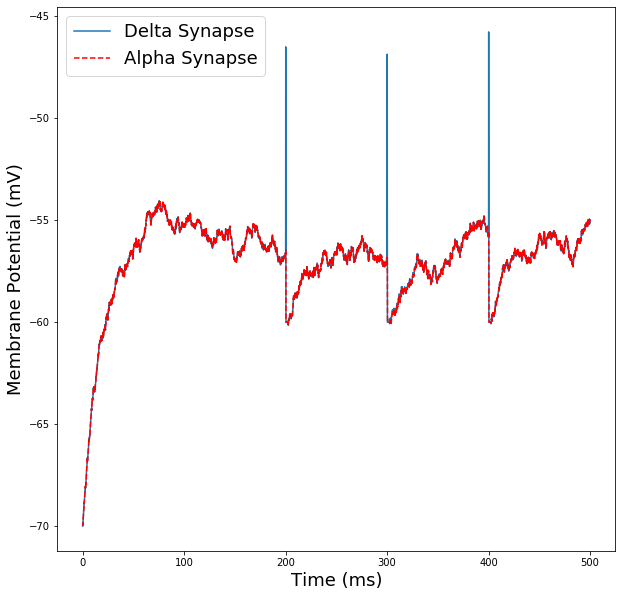

In [3]:
rcParams['figure.figsize'] = 10, 10
plot(monitorsE.t/ms, monitorsE.v[0]/mV)
plot(monitorsE_alpha.t/ms, monitorsE_alpha.v[0]/mV,'r--')
legend(('Delta Synapse','Alpha Synapse'),fontsize=18)
xlabel('Time (ms)',fontsize=18)
ylabel('Membrane Potential (mV)',fontsize=18)
